# Import Library

In [9]:
from selenium import webdriver

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='/Users/hoon/Library/Fonts/NanumSquareRegular.ttf').get_name()
plt.rc("font", family=font_name)
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import urllib.request as req
from urllib.request import urlopen
from urllib.request import HTTPError, URLError
import urllib.parse
from bs4 import BeautifulSoup
import requests

from tqdm import tqdm_notebook
import time

import re

# 1. 데이터 파악 및 EDA
- 전처리는 1월 5일까지 (가능하면 R로 독립(원인)변수들이 통계적으로 의미있는지 파악하는 것까지)
- 결과 변수 : 중식계, 석식계
- 원인 변수 : 일자, 요일, 본사정원수, 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수, 재택근무자수, 메뉴
- 파생 원인 변수 : 일자 -> 계절, 연도, 날씨(날씨 데이터 받아오기) // 인기메뉴 // 메뉴 카테고리화(어떻게 해야할지 고민해보기) // 실제 상주인원 계산 // 신메뉴 여부 // 명절 전날
- 전처리 : 메뉴, 요일 one-hot encoding // 일자 : datetype으로 // 값들이 다 이산변수이므로 int64가 적합. 다 바꿔주자 // 결측치 확인해보기. '0'으로 표시되어있는지 확인

In [10]:
data = pd.read_csv("data/train.csv")
data.head()
# 2018년 6월 1일 요일 오류

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [11]:
data.tail()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0
1204,2021-01-26,화,2983,69,183,551,362.0,모닝롤/야채샌드 우유/주스 계란후라이/찐계란 참치죽/흑미밥 홍합탕 애호박새우젓볶음 ...,쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치...,(New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기,1015.0,480.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [13]:
data.describe()
# 25% ~ 75% 까지의 차가 표준편차보다 급격히 작음.
# 전형적인 표준편차 형태를 보일 것으로 예상

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


## 1. EDA & 시각화

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'frequency')

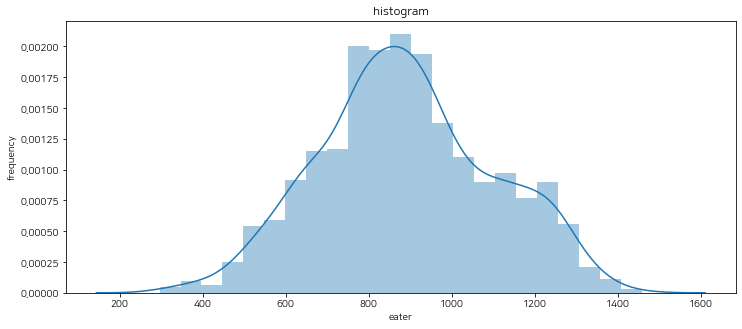

In [14]:
### 점심값 정규분포를 따른다.

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)

ax = sns.distplot(data['중식계'])
ax.set_title("histogram")
ax.set_xlabel("eater")
ax.set_ylabel("frequency")

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'frequency')

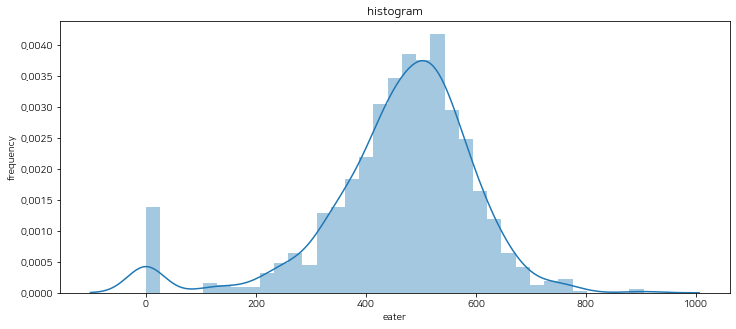

In [15]:
### 석식도 정규분포를 따른다.
### 0인 값도 많다. 석식은 운영하지 않는 경우도 있음을 유추할 수 있다. 

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)

ax = sns.distplot(data['석식계'])
ax.set_title("histogram")
ax.set_xlabel("eater")
ax.set_ylabel("frequency")

In [16]:
### 석식 0 파악하기
data[data['석식계'] == 0]

# 주로 석식을 운영하지 않은 날이나, 2017년 9월 27일과 2018년 2월 4일은 석식 운영했음에도 0으로 처리되어있음
# 석식계 분석시엔 해당 내용들은 제거 후 분석해줘야 더 정확한 분석이 가능할 것으로 예상

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
204,2016-11-30,수,2689,68,207,0,0.0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 ...,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,1109.0,0.0
224,2016-12-28,수,2705,166,225,0,0.0,모닝롤/고구마파이 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 북어계란국 ...,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,767.0,0.0
244,2017-01-25,수,2697,79,203,0,0.0,모닝롤/토마토샌드 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 ...,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,720.0,0.0
262,2017-02-22,수,2632,75,252,0,0.0,모닝롤/브라우니 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 꽃게탕 명엽채...,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,1065.0,0.0
281,2017-03-22,수,2627,53,235,0,0.0,모닝롤/찐빵 우유/주스 계란후라이 김치죽/쌀밥 (쌀:국내산) 콩나물국 김실파무침...,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,953.0,0.0
306,2017-04-26,수,2626,45,304,0,0.0,모닝롤/와플 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 된장찌개 검정콩조...,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,835.0,0.0
327,2017-05-31,수,2637,43,265,0,0.0,모닝롤/베이글 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 자...,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,910.0,0.0
346,2017-06-28,수,2648,58,259,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 쇠고기매운국 고...,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,745.0,0.0
366,2017-07-26,수,2839,254,246,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 민물새우찌개 숙...,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,797.0,0.0
392,2017-09-01,금,2642,177,303,45,0.0,모닝롤/단팥빵 우유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 대구찌개 깻순나...,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,663.0,0.0


<AxesSubplot:xlabel='요일', ylabel='중식계'>

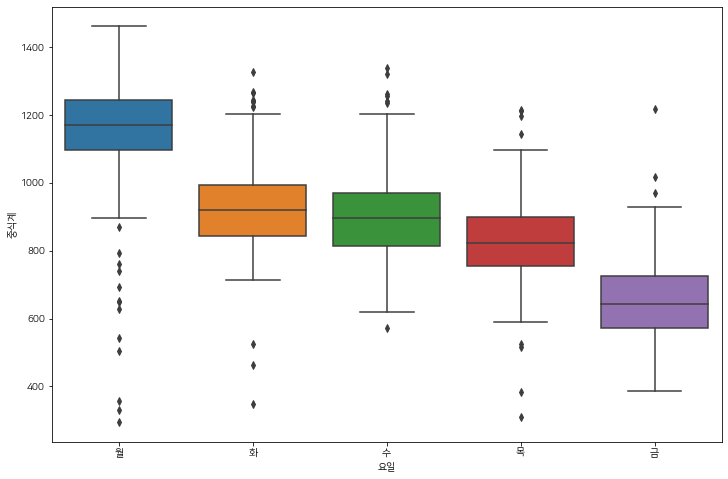

In [17]:
#### 요일별 중식계, 석식계
#### 평균적으로 월요일에 가장 많이 찾아오지만, 항상 그렇지 않다. 오차범위 밖에 최소값들이 많이 있음을 알 수 있다.
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 8)
sns.boxplot(x='요일', y='중식계', data=data)

<AxesSubplot:xlabel='요일', ylabel='석식계'>

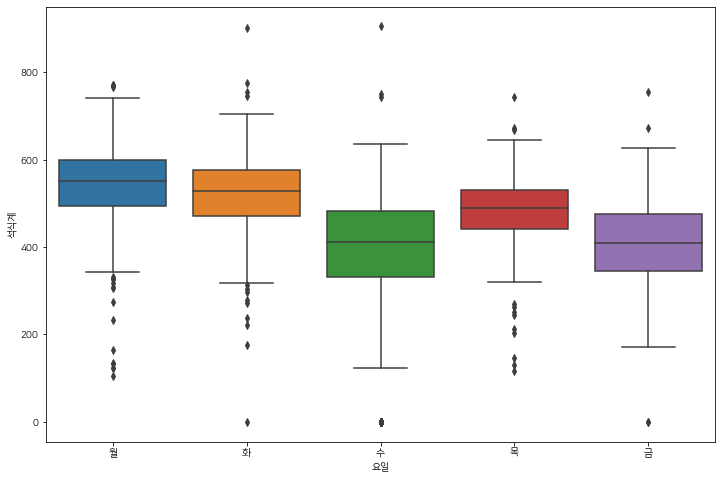

In [18]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 8)

sns.boxplot(x='요일', y='석식계', data=data)

## 2. 코로나 이후 데이터 EDA

In [19]:
# 2020-03-20 인덱스 찾아보니 1010
data.iloc[1010:, :]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
1010,2020-03-20,금,2950,176,263,3,135.0,모닝롤/허니브레드 우유/주스 계란후라이 야채죽/쌀밥 (쌀:국내산) 꽃게탕 (오징어...,"쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 갈비탕 (갈비:호주산) 칠리새우 감자채볶음 ...","쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 건새우아욱국 치즈함박스테이크 (돈육:국내,수...",627.0,358.0
1011,2020-03-23,월,2950,109,178,687,285.0,모닝롤/베이글 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 감자국 꽈리고추...,"쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 시래기국 오리양념불고기*쌈무 (오리:국내산)...","쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 닭개장 (닭:국내산) 삼치튀김*데리야끼 한식...",1110.0,651.0
1012,2020-03-24,화,2950,131,137,639,303.0,모닝롤/햄치즈샌드 우유/주스 계란후라이 잣죽/쌀밥 (쌀:국내산) 쑥국 수제어묵볶...,"쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 소고기미역국 (소고기:호주산) 해물누룽지탕 (...",오므라이스 (쌀:국내산) 가쯔오장국 돈육고구마강정 (돈육:국내산) 과일플레인샐러드...,1083.0,754.0
1013,2020-03-25,수,2950,122,146,1,303.0,모닝롤/고구마파이 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 피홍합탕 감...,"쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 유부주머니국 목살스테이크 (목살:국내산) 파...",찹쌀밥 장각닭죽 생야채*쌈짱 오렌지 하루야채주스 포기김치,1022.0,526.0
1014,2020-03-26,목,2950,133,133,584,288.0,모닝롤/바나나샌드 우유/주스 계란후라이 새송이죽/쌀밥 (쌀:국내산) 버섯매운탕 (...,"쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 배추된장국 제육볶음 (돈육:국내산) 계란찜 ...","멸치주먹밥 (쌀,현미흑미:국내산) 우동 해물까스*와사비소스 꽃맛살샐러드 무피클...",955.0,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0


<AxesSubplot:xlabel='현본사소속재택근무자수', ylabel='중식계'>

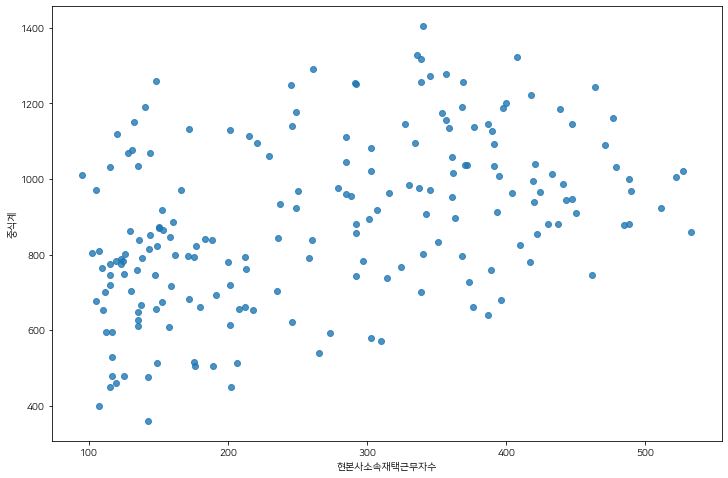

In [20]:
#코로나 이후, 재택근무자수와 중식계 관계. 뚜렷한 선형관계를 보이고 있진 않다.
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 8)


sns.regplot(x='현본사소속재택근무자수', y='중식계', data=data.iloc[1010:, :], fit_reg=False)

<AxesSubplot:xlabel='현본사소속재택근무자수', ylabel='석식계'>

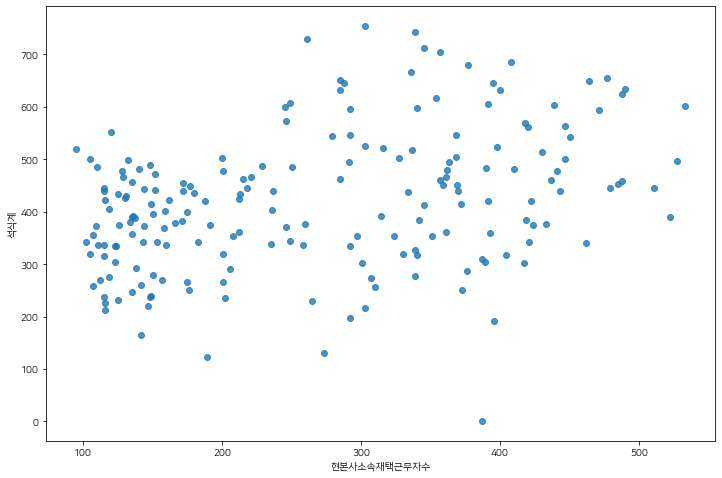

In [21]:
#코로나 이후, 재택근무자수와 석식계 관계. 마찬가지로 뚜렷한 선형관계를 보이고 있진 않다.
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 8)

sns.regplot(x='현본사소속재택근무자수', y='석식계', data=data.iloc[1010:, :], fit_reg=False)

## 3. 사내 근무자수, 이 외 관련 숫자와 중식계, 석식계 관계 파악해보기

In [22]:
# 사내 인원 관련 숫자와 중식계, 석식계의 관계를 상관관계로

# 1. 데이터 슬라이싱
data_a = data.loc[:, ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식계', '석식계']]
data_a

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
0,2601,50,150,238,0.0,1039.0,331.0
1,2601,50,173,319,0.0,867.0,560.0
2,2601,56,180,111,0.0,1017.0,573.0
3,2601,104,220,355,0.0,978.0,525.0
4,2601,278,181,34,0.0,925.0,330.0
...,...,...,...,...,...,...,...
1200,2983,75,198,4,391.0,1093.0,421.0
1201,2983,92,231,462,351.0,832.0,353.0
1202,2983,255,248,1,303.0,579.0,217.0
1203,2983,107,153,616,327.0,1145.0,502.0


In [23]:
# 2. 휴가자, 출장자, 재택근무자 제외한 실제 본사 내 정원 파악해보기

data_a['실질정원수'] = data_a['본사정원수'] - (data_a['본사휴가자수'] + data_a['본사출장자수'] + data_a['현본사소속재택근무자수'])


In [24]:
# 생성한 파생변수 위치 변경
data_a = data_a.loc[:, ['중식계', '석식계', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
data_a

,중식계,석식계,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,1039.0,331.0,2601,2401.0,50,150,238,0.0
1,867.0,560.0,2601,2378.0,50,173,319,0.0
2,1017.0,573.0,2601,2365.0,56,180,111,0.0
3,978.0,525.0,2601,2277.0,104,220,355,0.0
4,925.0,330.0,2601,2142.0,278,181,34,0.0
...,...,...,...,...,...,...,...,...
1200,1093.0,421.0,2983,2319.0,75,198,4,391.0
1201,832.0,353.0,2983,2309.0,92,231,462,351.0
1202,579.0,217.0,2983,2177.0,255,248,1,303.0
1203,1145.0,502.0,2983,2396.0,107,153,616,327.0


In [25]:
# int로 변경
data_a = data_a.astype(np.int64)
data_a

,중식계,석식계,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,1039,331,2601,2401,50,150,238,0
1,867,560,2601,2378,50,173,319,0
2,1017,573,2601,2365,56,180,111,0
3,978,525,2601,2277,104,220,355,0
4,925,330,2601,2142,278,181,34,0
...,...,...,...,...,...,...,...,...
1200,1093,421,2983,2319,75,198,4,391
1201,832,353,2983,2309,92,231,462,351
1202,579,217,2983,2177,255,248,1,303
1203,1145,502,2983,2396,107,153,616,327


<AxesSubplot:>

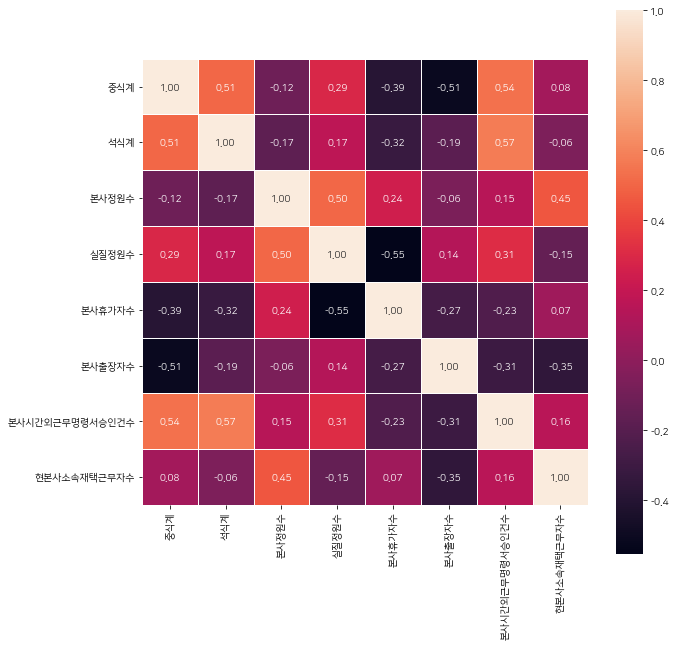

In [26]:
cols = ['중식계', '석식계', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']

plt.figure(figsize=(10,10))

heat = np.corrcoef(data_a[cols].T)
sns.heatmap(heat, annot=True, yticklabels=cols, xticklabels=cols, fmt='.2f', linewidths=.5, square=True)

In [27]:
# 1. 중식계(점심)은 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수
# 이 세 값이 상관관계가 큰 이유는 휴가자와 출장자는 근무지에 없어서!
# 점심이 본사시간외근무명령서승인건수와 관련 있는 이유는 바쁘니까 야근하고 바쁘니까 밖에서 밥먹을 시간이 없는 것으로 이해

<AxesSubplot:xlabel='본사시간외근무명령서승인건수', ylabel='중식계'>

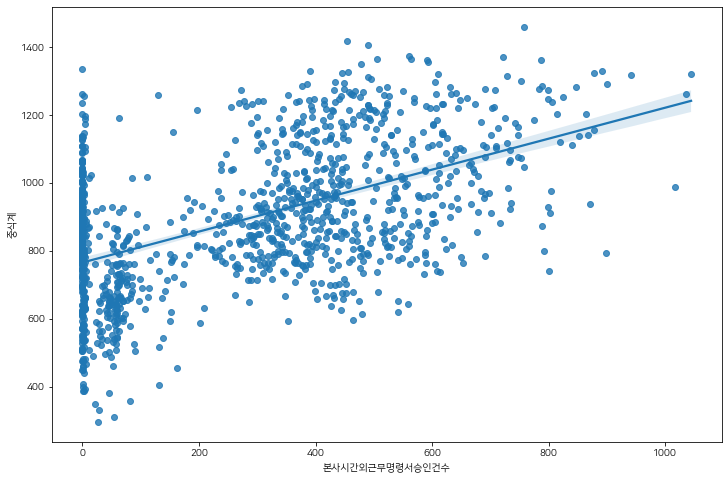

In [28]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 8)

sns.regplot(x="본사시간외근무명령서승인건수", y='중식계', data=data_a)

<AxesSubplot:xlabel='본사시간외근무명령서승인건수', ylabel='석식계'>

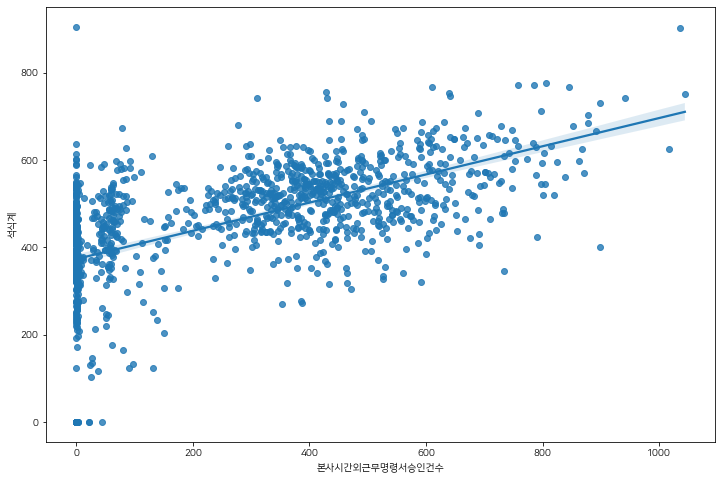

In [29]:
# 데이터가 선형관계에 있으나 근무명령승인건수에 관계없이 석식계, 중식계 발생하는 건수도 많음을 알 수 있음
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 8)

sns.regplot(x="본사시간외근무명령서승인건수", y='석식계', data=data_a)

<AxesSubplot:xlabel='중식계', ylabel='석식계'>

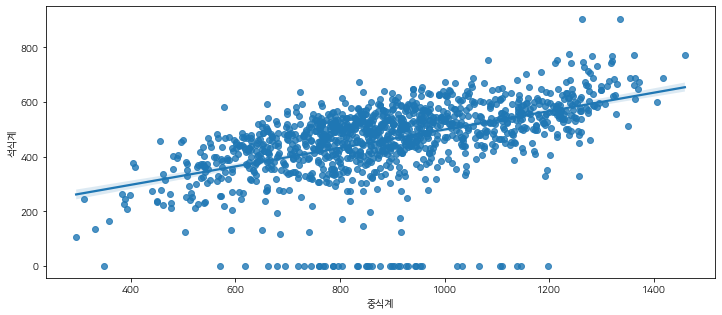

In [30]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)

sns.regplot(x="중식계", y='석식계', data=data_a)
# 중식계가 많은 날, 석식계도 많다 :)
# 석식계를 예측할 땐, 중식계를 원인변수로 두는 것도 하나의 방법

# 2. 데이터 변경

## 1. 데이터 형태 변경
- 일자 -> 날짜 데이터 형태로
- 인원 수 -> int로 :: 해당 데이터 기준은 인원 수이고 사람은 정확히 끊어서 셀 수 있다.

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [32]:
data['일자'] = pd.to_datetime(data['일자'])
#df['Datetime'] = df['Datetime'].apply(lambda _: datetime.strptime(_,"%m/%d/%Y, %H:%M:%S"))
#지금은 데이터 크기가 작아서... 데이터가 크면 아래 코드가 성능이 더 좋다고 함
data

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0


In [33]:
data['현본사소속재택근무자수'] = data['현본사소속재택근무자수'].astype(np.int64)
data['중식계'] = data['중식계'].astype(np.int64)
data['석식계'] = data['석식계'].astype(np.int64)

In [34]:
### 시계열에 따른 변화량을 시각화.
### 1. date type을 인덱스로
data_timegraph = data.set_index('일자')
data_timegraph

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
일자,,,,,,,,,,,
2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331
2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560
2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573
2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525
2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-20,수,2983,75,198,4,391,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421
2021-01-21,목,2983,92,231,462,351,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353
2021-01-22,금,2983,255,248,1,303,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217


<AxesSubplot:xlabel='일자'>

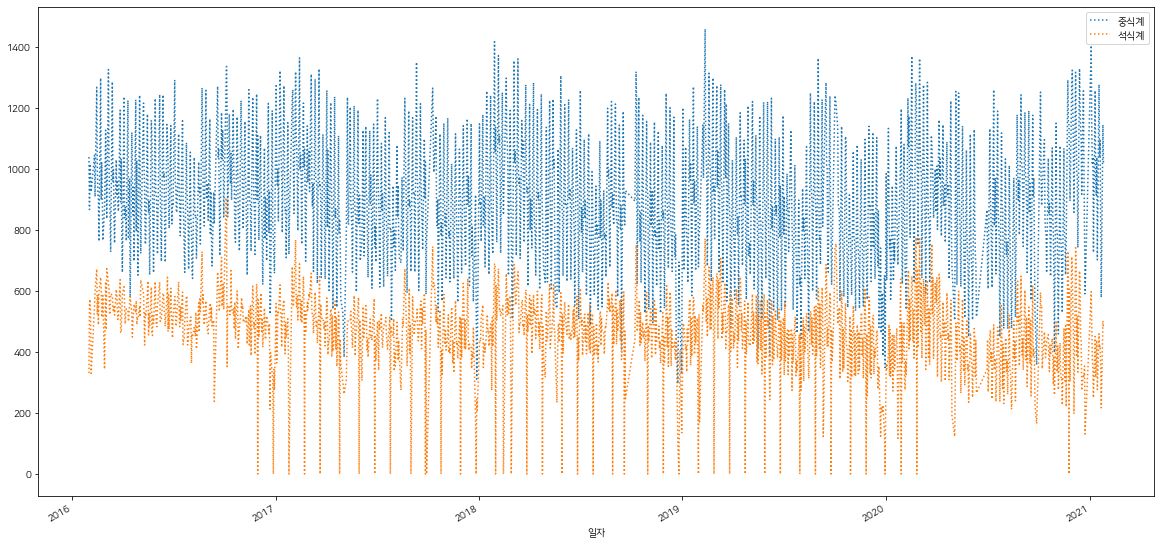

In [35]:
### 2. 중식계와 석식계 변화량 파악
### 매년, 계절별, 월별로 일정한 패턴을 보이는 듯함
### 중식계와 석식계는 비슷한 증감 패턴을 보인다
### 코로나 직후, 석식량은 오히려 코로나 전에 비해 늘어난 모습을 보인다.
graph = data_timegraph.loc[:, ['중식계', '석식계']]
graph.plot(figsize=(20,10), ls=':')

<AxesSubplot:xlabel='일자'>

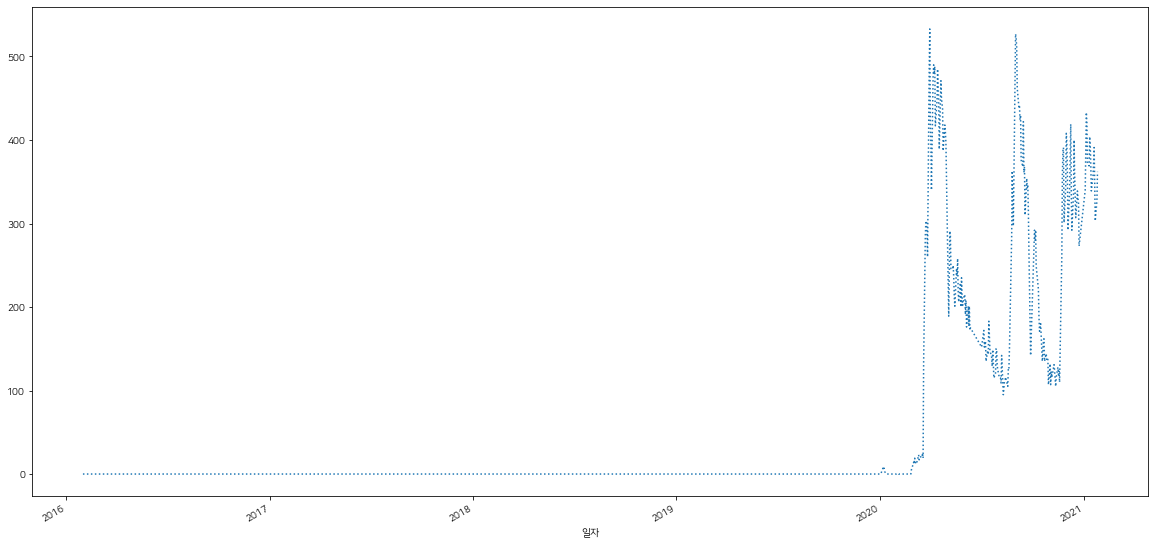

In [36]:
### 3. 재택근무자 수 변화량 파악
### 코로나 19 이 후 급격히 늘어나는 모습을 보임
graph = data_timegraph.loc[:, '현본사소속재택근무자수']
graph.plot(figsize=(20,10), ls=':')

<AxesSubplot:xlabel='일자'>

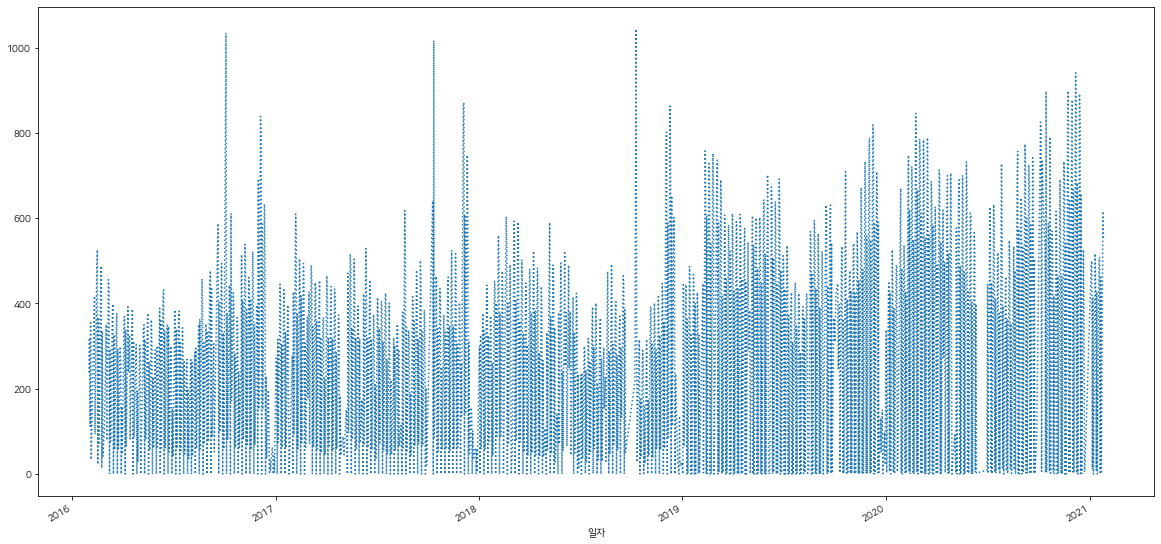

In [37]:
### 4. 야근자 수 변화량 파악
### 16년, 17년, 18년엔 특정 날짜에 시간외근무명령승인건수가 증가
### 다만, 19년과 20년도엔 이러한 패턴이 안보임.
### 이유를 찾고 21년도는 이를 기준으로 야근자 수가 늘어날지 안늘어날지 파악하는 것 필요해보임
graph = data_timegraph.loc[:, '본사시간외근무명령서승인건수']
graph.plot(figsize=(20,10), ls=':')

## 2. 근무자 관련 파생변수
- 사내 실 근무자 수 파악

In [38]:
data.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560
2,2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525
4,2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330


In [39]:
data['실질정원수'] = data['본사정원수'] - (data['본사휴가자수'] + data['본사출장자수'] + data['현본사소속재택근무자수'])

data = data.loc[:, ['일자', '요일', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식메뉴', '석식메뉴', '중식계', '석식계']]
data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502


## 3. 일자에서 계절, 연도, 월, 날 뽑아내기

In [40]:
data['일자']

0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]

In [41]:
data['Month'] = data['일자'].dt.strftime('%m')
data['Date'] = data['일자'].dt.strftime('%d')
# data['Month'] = data['일자'].dt.month
# data['Date'] = data['일자'].dt.day

data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,02,01
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,02,02
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,02,03
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,02,04
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,02,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,01,20
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,01,21
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,01,22
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,01,25


In [42]:
data['Month']

0       02
1       02
2       02
3       02
4       02
        ..
1200    01
1201    01
1202    01
1203    01
1204    01
Name: Month, Length: 1205, dtype: object

In [43]:
### 계절추가
season = []

for index in range(len(data)):
    if data['Month'][index] == '03' or data['Month'][index] == '04' or data['Month'][index] == '05':
        season.append('봄')
    elif data['Month'][index] == '06' or data['Month'][index] == '07' or data['Month'][index] == '08':
        season.append('여름')
    elif data['Month'][index] == '09' or data['Month'][index] == '10' or data['Month'][index] == '11':
        season.append('가을')
    elif data['Month'][index] == '12' or data['Month'][index] == '01' or data['Month'][index] == '02':
        season.append('겨울')

len(season)

1205

In [44]:
data['Season'] = season
data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,02,01,겨울
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,02,02,겨울
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,02,03,겨울
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,02,04,겨울
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,02,05,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,01,20,겨울
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,01,21,겨울
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,01,22,겨울
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,01,25,겨울


## Checkpoint(2021.01.03 15pm)
- 데이터 타입 변경 / 실제 사내 근무자 수 파악 / 계절 변수 추가

In [45]:
data.to_csv("data/20220103.csv", encoding='utf-8', index=False)

## 4. 메뉴
- 조식메뉴제거(앞에서 이미 제거 했음)
- 신메뉴 출시 카테고리 만들어주기
- 중식, 석식 메뉴에서 주요 메뉴 뽑아내기
- 메뉴 카테고리화 밥 or 특별식 밥 // 메인메뉴 // 국
- 중식, 석식 신메뉴 Yes or No 칼럼 만들기


In [46]:
data = pd.read_csv("data/20220103.csv")

In [47]:
#밥
print(data['중식메뉴'][0].split(' ')[0])
#국
print(data['중식메뉴'][0].split(' ')[2])
#메인반찬
print(data['중식메뉴'][0].split(' ')[4])

### 밥이 메인이면?
#밥
print(data['중식메뉴'][2].split(' ')[0])
#국
print(data['중식메뉴'][2].split(' ')[2])
#메인반찬
print(data['중식메뉴'][2].split(' ')[4])


### 뒤엔 원산지가 없어서 순서가 다르다. 단순 반복문과 split으론 원하는 결과물 얻을 수 없다.
#밥
print(data['중식메뉴'][1202].split(' ')[0])
#국 #요거닭이 나와
print(data['중식메뉴'][1202].split(' ')[2])
#메인반찬
print(data['중식메뉴'][1202].split(' ')[4])

# 일관된 결과물 얻으려면 원산지 정보를 제거해줘야한다.
# split으로 나누고 반복문과 조건문으로 ()가 있으면 제거하라는 명령어 통해 원산지 정보만 없앨 수 있다.

쌀밥/잡곡밥
오징어찌개
쇠불고기
카레덮밥
팽이장국
치킨핑거
전주비빔밥*약고추장
요거닭
파프리카해초무침


In [48]:
'New' in data['석식메뉴'][1204]

True

In [49]:
New_lunch = []
New_dinner = []

for index in range(len(data)):
    if 'New' in data['중식메뉴'][index]:
        New_lunch.append('Y')
    else:
        New_lunch.append('N')

for index in range(len(data)):
    if 'New' in data['석식메뉴'][index]:
        New_dinner.append('Y')
    else:
        New_dinner.append('N')

print(len(New_lunch))
print(len(New_dinner))

1205
1205


In [50]:
data['New_lunch'] = New_lunch
data['New_dinner'] = New_dinner

data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season,New_lunch,New_dinner
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2,1,겨울,N,N
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2,2,겨울,N,N
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2,3,겨울,N,N
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2,4,겨울,N,N
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2,5,겨울,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,1,20,겨울,N,N
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,1,21,겨울,N,N
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,1,22,겨울,N,N
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,1,25,겨울,N,N


## checkpoint(2021.01.03 16pm)
- 신메뉴 칼럼 생성

In [51]:
data.to_csv("data/20220103.csv", encoding='utf-8', index=False)

In [52]:
data = pd.read_csv("data/20220103.csv")

### 1. 중식

In [53]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch = []

for index in range(len(data)):
    tmp = data.loc[index,'중식메뉴'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    # ()안에 있는 내용 제거
    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch.append(tmp) 

In [54]:
for index in range(len(data)): # 밥은 큰 차이가 없을것같으므로 쌀밥은 다 밥으로 통일
    if '쌀밥' in lunch[index][0]:
        lunch[index][0] = '밥'

In [55]:
lunch[:3]

[['밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치']]

In [56]:
# 밥, 국, 메인반찬1로 나누기
# 원핫 인코딩하면 너무 길어질 거 같은데.. 간단히 카테고리화할 방법 찾아야하나?
# 길이 신경 안써도 되나?
rice=[]
soup=[]
main=[]

for i in range(len(data)):
    if lunch[i][0]:
        rice.append(lunch[i][0])
    if lunch[i][1]:
        soup.append(lunch[i][1])
    if lunch[i][2]:
        main.append(lunch[i][2])

data['lunch_rice'] = rice
data['lunch_soup'] = soup
data['lunch_main'] = main

In [57]:
print(data['lunch_rice'].unique())

['밥' '카레덮밥' '낙지비빔밥' '비빔밥' '곤드레밥' '콩나물밥*달래장' '봄새싹비빔밥' '콩나물밥' '나물비빔밥'
 '단호박영양밥' '산채비빔밥' '낙지볶음밥' '열무비빔밥' '참치회덮밥' '연복풍덮밥' '열무보리비빔밥' '불고기덮밥'
 '산채비빔밥*강된장' '짜장밥' '버섯영양밥' '소불고기덮밥' '오곡밥' '곤드레밥*강된장' '봄나물비빔밥' '카레라이스'
 '짜장덮밥' '<초복특식>' '김치제육덮밥' '곤드레밥*간장양념' '단호박카레라이스' '곤드레밥*양념장' '삼계탕'
 '콩나물밥*양념장' '마파두부덮밥' '야채볶음밥*짜장소스' '김치볶음밥' '오므라이스' '김치볶음밥/계란' '파인애플볶음밥'
 '김치필라프' '불고기비빔밥' '김밥볶음밥' '고기듬뿍카레라이스' '건강비빔밥*약고추장' '새우날치알볶음밥' '소고기콩나물밥*양념'
 '닭살카레라이스' '열무보리비빔밥/강된장' '베이컨김치볶음밥' '돈육버섯고추장덮밥' '비빔밥*약고추장' '낙지비빔밥*계란후라이'
 '계란채소볶음밥' '전주비빔밥' '호박된장국' '전주비빔밥*약고추장']


In [58]:
data[data['lunch_rice'] == '<초복특식>']
#이거 어떻게 처리할까? 그냥 둘까?

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main
356,2017-07-12,수,2839,2507,69,263,0,0,"<초복특식> 삼계탕 (닭:국내산) 찹쌀밥 (찹쌀,쌀:국내산) 생야채&쌈장 수박 ...",쌀밥/잡곡밥 (쌀:국내산) 해물된장찌개 모둠장조림 참치야채전 노각무침 포기김...,918,414,7,12,여름,N,N,<초복특식>,삼계탕,찹쌀밥
840,2019-07-12,금,2760,2210,244,306,0,0,"<초복특식> 삼계탕 (닭:국내산) 찹쌀밥 (찹쌀,쌀:국내산) 생야채&쌈장 수박 ...",쌀밥/잡곡밥 (쌀:국내산) 된장찌개 소고기장조림 (쇠고기:호주산) 비엔나케찹볶음 ...,856,385,7,12,여름,N,N,<초복특식>,삼계탕,찹쌀밥


In [59]:
data.head(20)

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2,1,겨울,N,N,밥,오징어찌개,쇠불고기
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2,2,겨울,N,N,밥,김치찌개,가자미튀김
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2,3,겨울,N,N,카레덮밥,팽이장국,치킨핑거
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2,4,겨울,N,N,밥,쇠고기무국,주꾸미볶음
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2,5,겨울,N,N,밥,떡국,돈육씨앗강정
5,2016-02-11,목,2601,2075,383,143,417,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045,550,2,11,겨울,N,N,밥,시래기국,훈제오리구이
6,2016-02-12,금,2601,2056,389,156,93,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909,598,2,12,겨울,N,N,밥,꽃게탕,돈육굴소스볶음
7,2016-02-15,월,2601,2310,87,204,482,0,쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 ...,"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수...",1268,672,2,15,겨울,N,N,밥,시금치국,닭감자조림
8,2016-02-16,화,2601,2293,72,236,526,0,쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 (쇠고기:호주산) 탕수어 (동태:러시아산) 오...,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 쇠불고기 (쇠고기:호주산) 해파리겨자채 봄동...,1014,523,2,16,겨울,N,N,밥,쇠고기무국,탕수어
9,2016-02-17,수,2601,2273,78,250,23,0,쌀밥/잡곡밥 (쌀:국내산) 냉이된장국 쇠고기장조림 (쇠고기:호주산) 통도라지구이 ...,볶음밥*자장소스 (쌀:국내산) 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치 ...,916,588,2,17,겨울,N,N,밥,냉이된장국,쇠고기장조림


### 석식

In [60]:
dinner = []

for index in range(len(data)):
    tmp = data.loc[index,'석식메뉴'].split(' ')
    tmp = ' '.join(tmp).split()

    for menu_d in tmp:
        if '(' in menu_d:
            tmp.remove(menu_d)
    dinner.append(tmp)

In [61]:
print(len(data))
print(len(dinner))
print(len(lunch))


1205
1205
1205


In [62]:
dinner[0:10]

[['쌀밥/잡곡밥', '육개장', '자반고등어구이', '두부조림', '건파래무침', '포기김치'],
 ['콩나물밥*양념장', '어묵국', '유산슬', '아삭고추무침', '바나나', '포기김치'],
 ['쌀밥/잡곡밥', '청국장찌개', '황태양념구이', '고기전', '새송이버섯볶음', '포기김치'],
 ['미니김밥*겨자장', '우동', '멕시칸샐러드', '군고구마', '무피클', '포기김치'],
 ['쌀밥/잡곡밥', '차돌박이찌개', '닭갈비', '감자소세지볶음', '콩나물무침', '포기김치'],
 ['참치회덮밥', '맑은국', '군만두', '과일샐러드', '락교', '포기김치'],
 ['쌀밥/잡곡밥', '김치콩나물국', '미니함박', '어묵볶음', '물파래무침', '깍두기'],
 ['쌀밥/잡곡밥', '홍합미역국', '등갈비김치찜', '임연수구이', '브로컬리초장', '포기김치'],
 ['쌀밥/잡곡밥', '된장찌개', '쇠불고기', '해파리겨자채', '봄동무침', '포기김치'],
 ['볶음밥*자장소스', '맑은국', '새우또띠아', '쨔샤이무침', '요플레', '포기김치']]

In [63]:
# 저녁은 빈 값이 있다. 그래서 점심과 똑같은 코드로 진행하면 out of range 에러가 뜬다.
# 저녁메뉴가 비어있는 경우, 저녁메뉴가 * 되어 있는 경우 등등을 모두 조건문으로 달아야 한다.

dinner_rice=[]
dinner_soup=[]
dinner_main=[]


for word in dinner:
    
    
    if len(word) == 0:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '*' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '가정의날' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '가정의달' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '자기계발의날' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '*자기계발의날*' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '자기개발의날' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')

    else:
        dinner_rice.append(word[0])
        dinner_soup.append(word[1])
        dinner_main.append(word[2])

In [64]:
data['dinner_rice'] = dinner_rice
data['dinner_soup'] = dinner_soup
data['dinner_main'] = dinner_main

In [65]:
print(data['dinner_rice'][0])
print(data['dinner_rice'].unique())
# 흑미밥과 쌀밥이 일반식 밥

쌀밥/잡곡밥
['쌀밥/잡곡밥' '콩나물밥*양념장' '미니김밥*겨자장' '참치회덮밥' '볶음밥*자장소스' '김밥' '멸치주먹밥' '카레덮밥'
 '볶음밥' '짜장잡채덮밥' '토마토스파게티' '굴소스파인볶음밥' '햄볶음밥' '주먹밥' '김치볶음밥' '치킨마요덮밥' '비빔밥'
 '낙지비빔밥' '오므라이스' '짜장덮밥' '참치주먹밥' '김치볶음밥/계란' '돈까스김밥' '유부초밥' '새우살볶음밥' '짜장잡채밥'
 '날치알볶음밥' '충무김밥' '김밥/맑은국' '작은밥/맑은국' '볶음밥/짜장소스' '콩나물밥' '카레라이스' '작은밥'
 '김밥볶음밥' '콩국수' '굴소스해물볶음밥' '쇠고기숙주규동덮밥' '통새우김밥' '나가사키면&김' '옛날왕돈까스' '낙지볶음덮밥'
 '생선초밥' '후난식볶음밥' 'None' '해물굴소스볶음밥' '마파두부덮밥' '김치참치주먹밥' '쇠고기덮밥' '날치알김치볶음밥'
 '참치야채비빔밥' '베이컨김치볶음밥' '해물볶음밥' '나가사끼짬뽕' '닭갈비볶음밥' '야채볶음밥' '꼬마김밥*겨자장'
 '소고기주먹밥' '빠에야' '목살필라프' '김치주먹밥' '산채비빔밥' '낙지덮밥' '볶음밥*짜장소스' '(쌀:국내산)'
 '볶음밥&짜장소스' '하와이안필라프' '야채주먹밥' '곤드레밥*강된장' '투움바스파게티' '짜장밥' '새우볶음밥'
 '쌀밥/옛날돈까스' '잡채밥&짜장소스' '파인애플볶음밥' '삼겹살볶음밥' '잡채밥/짜장소스' '베이컨볶음밥' '중국식볶음밥'
 '제육김치덮밥' '김치필라프' '참치덮밥' '쌀밥' '짜장면/작은밥' '참치마요덮밥' '굴소스볶음밥' '쇠고기볶음밥' '스팸주먹밥'
 '유산슬덮밥' '버섯영양밥*우렁양념장' '찹쌀밥' '마늘베이컨볶음밥' '스팸볶음밥' '불고기필라프' '땡초주먹밥'
 '부채살오므라이스' '계란김밥' '삼겹살마늘볶음밥' '후리가케덮밥' '채소볶음밥&자장소스' '흑미밥' '우육비빔냉면'
 '타워함박스테이크' '오리훈제볶음밥' '폭탄주먹밥' '계란볶음밥' '쇠고기규동덮밥' '청양멸치주먹밥' '채소라면' '미역국'
 '우거지국' '애

In [66]:
for index in range(len(data)):
    if '쌀밥' in data['dinner_rice'][index]:
        data['dinner_rice'][index] = '밥'
    elif '흑미밥' in data['dinner_rice'][index]:
        data['dinner_rice'][index] = '밥'

/var/folders/dx/ny9cjsmd1bb3r42zbp694xkh0000gn/T/ipykernel_5159/2007830346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dinner_rice'][index] = '밥'
/var/folders/dx/ny9cjsmd1bb3r42zbp694xkh0000gn/T/ipykernel_5159/2007830346.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dinner_rice'][index] = '밥'


In [67]:
# 중식메뉴, 석식메뉴 뽑아냈으니 제거
del data['중식메뉴']
del data['석식메뉴']
data

### 카테고리화, 정규화, 표준화는 데이터프레임 완성 후 한번에

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,1,겨울,N,N,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,2,겨울,N,N,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,3,겨울,N,N,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,4,겨울,N,N,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,5,겨울,N,N,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,20,겨울,N,N,밥,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침
1201,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,21,겨울,N,N,밥,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이
1202,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,22,겨울,N,N,전주비빔밥*약고추장,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육
1203,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,25,겨울,N,N,밥,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스


In [68]:
data.to_csv("data/20220104.csv", encoding='utf-8', index=False)

## 5. 날씨

- data from : https://www.weather.go.kr/weather/climate/past_table.jsp?stn=108&x=11&y=9&yy=2016&obs=07

In [69]:
data = pd.read_csv("data/20220104.csv")
data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,1,겨울,N,N,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,2,겨울,N,N,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,3,겨울,N,N,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,4,겨울,N,N,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,5,겨울,N,N,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,20,겨울,N,N,밥,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침
1201,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,21,겨울,N,N,밥,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이
1202,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,22,겨울,N,N,전주비빔밥*약고추장,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육
1203,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,25,겨울,N,N,밥,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스


In [70]:
weather = pd.read_csv("data/weather.csv", encoding='euc-kr')
weather

,지점,지점명,일시,평균기온(°C),일강수량(mm),평균 상대습도(%)
0,192,진주,2016-02-01,-0.6,NaN,43.9
1,192,진주,2016-02-02,-2.3,NaN,47.5
2,192,진주,2016-02-03,-1.7,NaN,57.1
3,192,진주,2016-02-04,-0.2,NaN,53.4
4,192,진주,2016-02-05,1.3,NaN,44.4
...,...,...,...,...,...,...
2158,192,진주,2021-12-31,-0.2,NaN,33.3
2159,192,진주,2022-01-01,-2.0,NaN,42.0
2160,192,진주,2022-01-02,-0.7,NaN,56.4
2161,192,진주,2022-01-03,-0.7,NaN,56.3


In [71]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   지점          2163 non-null   int64  
 1   지점명         2163 non-null   object 
 2   일시          2163 non-null   object 
 3   평균기온(°C)    2162 non-null   float64
 4   일강수량(mm)    702 non-null    float64
 5   평균 상대습도(%)  2163 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 101.5+ KB


In [72]:
weather['일자'] = pd.to_datetime(weather['일시'])
del weather['일시']
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   지점          2163 non-null   int64         
 1   지점명         2163 non-null   object        
 2   평균기온(°C)    2162 non-null   float64       
 3   일강수량(mm)    702 non-null    float64       
 4   평균 상대습도(%)  2163 non-null   float64       
 5   일자          2163 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 101.5+ KB


In [73]:
# 불필요한 지점, 지점명 제거
del weather['지점']
del weather['지점명']
weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일자
0,-0.6,NaN,43.9,2016-02-01
1,-2.3,NaN,47.5,2016-02-02
2,-1.7,NaN,57.1,2016-02-03
3,-0.2,NaN,53.4,2016-02-04
4,1.3,NaN,44.4,2016-02-05
...,...,...,...,...
2158,-0.2,NaN,33.3,2021-12-31
2159,-2.0,NaN,42.0,2022-01-01
2160,-0.7,NaN,56.4,2022-01-02
2161,-0.7,NaN,56.3,2022-01-03


In [74]:
weather['일강수량(mm)']=weather['일강수량(mm)'].replace({np.NaN:0})

weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일자
0,-0.6,0.0,43.9,2016-02-01
1,-2.3,0.0,47.5,2016-02-02
2,-1.7,0.0,57.1,2016-02-03
3,-0.2,0.0,53.4,2016-02-04
4,1.3,0.0,44.4,2016-02-05
...,...,...,...,...
2158,-0.2,0.0,33.3,2021-12-31
2159,-2.0,0.0,42.0,2022-01-01
2160,-0.7,0.0,56.4,2022-01-02
2161,-0.7,0.0,56.3,2022-01-03


In [75]:
weather.to_csv("data/weather_edit.csv", encoding="utf-8", index=False)

In [76]:
weather = pd.read_csv("data/weather_edit.csv")
weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일자
0,-0.6,0.0,43.9,2016-02-01
1,-2.3,0.0,47.5,2016-02-02
2,-1.7,0.0,57.1,2016-02-03
3,-0.2,0.0,53.4,2016-02-04
4,1.3,0.0,44.4,2016-02-05
...,...,...,...,...
2158,-0.2,0.0,33.3,2021-12-31
2159,-2.0,0.0,42.0,2022-01-01
2160,-0.7,0.0,56.4,2022-01-02
2161,-0.7,0.0,56.3,2022-01-03


In [77]:
# data에서 월, 날짜 추출했더니 다시 object형으로 바뀜
# datetime 형으로 바꿔주기

data['일자'] = pd.to_datetime(data['일자'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   실질정원수           1205 non-null   int64         
 4   본사휴가자수          1205 non-null   int64         
 5   본사출장자수          1205 non-null   int64         
 6   본사시간외근무명령서승인건수  1205 non-null   int64         
 7   현본사소속재택근무자수     1205 non-null   int64         
 8   중식계             1205 non-null   int64         
 9   석식계             1205 non-null   int64         
 10  Month           1205 non-null   int64         
 11  Date            1205 non-null   int64         
 12  Season          1205 non-null   object        
 13  New_lunch       1205 non-null   object        
 14  New_dinner      1205 non-null   object        
 15  lunc

In [78]:
# 에러가 떠서 확인해보니 일자 dtpye이 object
# 저장하면 이렇게 되는건가?
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   평균기온(°C)    2162 non-null   float64
 1   일강수량(mm)    2163 non-null   float64
 2   평균 상대습도(%)  2163 non-null   float64
 3   일자          2163 non-null   object 
dtypes: float64(3), object(1)
memory usage: 67.7+ KB


In [79]:
weather['일자'] = pd.to_datetime(weather['일자'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   평균기온(°C)    2162 non-null   float64       
 1   일강수량(mm)    2163 non-null   float64       
 2   평균 상대습도(%)  2163 non-null   float64       
 3   일자          2163 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 67.7 KB


In [80]:
data_weather = pd.merge(data, weather, how='inner', on='일자')
data_weather

# 총 갯수가 1204개 :: 하나가 줄어드는 이유는 기상 데이터에 누락된 날짜가 있다는 의미?
# 판다스 데이트타임 형태는 저장 후 불러드리면 object로 불러진다. 일일이 이거 지정해주는 것도 일이다.
# 이 때 parse_dates=['col_name'] 인자를 달아주면 된다.

# weather = pd.read_csv("data/weather_edit.csv", parse_dates=['일자'])
# data = pd.read_csv("data/20210103.csv", parse_dates=['일자'])

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,New_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main,평균기온(°C),일강수량(mm),평균 상대습도(%)
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,N,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,-0.6,0.0,43.9
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,N,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬,-2.3,0.0,47.5
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,N,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,-1.7,0.0,57.1
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,N,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드,-0.2,0.0,53.4
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,N,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,1.3,0.0,44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,N,밥,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,-0.4,0.0,64.0
1200,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,N,밥,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이,5.2,1.7,77.8
1201,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,N,전주비빔밥*약고추장,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육,7.0,1.2,97.5
1202,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,N,밥,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스,6.3,0.0,75.8


In [81]:
data_weather.columns

Index(['일자', '요일', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '중식계', '석식계', 'Month', 'Date', 'Season', 'New_lunch',
       'New_dinner', 'lunch_rice', 'lunch_soup', 'lunch_main', 'dinner_rice',
       'dinner_soup', 'dinner_main', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)'],
      dtype='object')

## checkpoint
- 2022.01.04
- 날씨 데이터까지 결합 완료
- 해야할 일 :
    + 0. 칼럼명 영어로 바꿔주기
    
    + 1. lunch df / dinner df 둘로 나눠야
    + 2. encoding - onehot / dummy / minmax / dtype:category화 + df.cat.codes
    + 3. transform 함수에 인코딩과 데이터프레임 나누는 것 추가하기
    + 4. 날씨 데이터를 테스트와 제출 날짜, 즉 2021.04.26까지 가져와야한다.
    + 5. 함수로 데이터 형태 다 바꿔주기

In [82]:
data_weather.to_csv("data/20220104.csv", encoding='utf-8', index=False)

In [83]:
data_weather = pd.read_csv("data/20220104.csv")
data_weather

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,New_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main,평균기온(°C),일강수량(mm),평균 상대습도(%)
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,N,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,-0.6,0.0,43.9
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,N,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬,-2.3,0.0,47.5
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,N,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,-1.7,0.0,57.1
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,N,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드,-0.2,0.0,53.4
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,N,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,1.3,0.0,44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,N,밥,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,-0.4,0.0,64.0
1200,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,N,밥,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이,5.2,1.7,77.8
1201,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,N,전주비빔밥*약고추장,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육,7.0,1.2,97.5
1202,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,N,밥,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스,6.3,0.0,75.8


## 6. 칼럼 영어로

- df.columns = [' ',' ',' ']
    + 모두 바꾸고 싶을 땐 이게 더 편하다.
- df.rename(columns={'기존칼럼명' : '바꿀칼럼명'}, inplace=True)
    + 특정 칼럼만 바꾸고 싶을 땐 이게 더 편하다.

In [84]:
data_weather.columns

Index(['일자', '요일', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '중식계', '석식계', 'Month', 'Date', 'Season', 'New_lunch',
       'New_dinner', 'lunch_rice', 'lunch_soup', 'lunch_main', 'dinner_rice',
       'dinner_soup', 'dinner_main', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)'],
      dtype='object')

In [85]:
# '일자', '요일', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
# '현본사소속재택근무자수', '중식계', '석식계', 'Month', 'Date', 'Season', 'New_lunch',
# 'New_dinner', 'lunch_rice', 'lunch_soup', 'lunch_main', 'dinner_rice',
# 'dinner_soup', 'dinner_main', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '일 최심신적설(cm)'

# 일자 -> datetime
# 요일 -> weekdays
# 본사정원수 -> worker_number
# 실징정원수 -> real_number
# 본사휴가자수 -> vacation_number
# 본사출장자수 -> biztrip_number
# 본사시간외근무명령서승인건수 -> overtime_number
# 현본사소속재택근무자수 -> telecom_number *재택근무 = telecommuting
# 중식계 -> lunch_number
# 석식계 -> dinner_number
# 평균기온 -> temperature
# 강수량 -> rain
# 습도 -> humidity

col_eng = ['datetime', 'weekdays', 'worker_number', 'real_number', 'vacation_number', 'biztrip_number', 'overtime_number', 'telecom_number', 'lunch_number',
'dinner_number', 'month', 'date', 'season', 'new_lunch', 'new_dinner', 'lunch_rice', 'lunch_soup', 'lunch_main', 'dinner_rice', 'dinner_soup', 'dinner_main',
'temperature', 'rain', 'humidity']

data_weather.columns=col_eng
data_weather

,datetime,weekdays,worker_number,real_number,vacation_number,biztrip_number,overtime_number,telecom_number,lunch_number,dinner_number,...,new_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main,temperature,rain,humidity
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,N,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,-0.6,0.0,43.9
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,N,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬,-2.3,0.0,47.5
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,N,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,-1.7,0.0,57.1
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,N,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드,-0.2,0.0,53.4
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,N,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,1.3,0.0,44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,N,밥,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,-0.4,0.0,64.0
1200,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,N,밥,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이,5.2,1.7,77.8
1201,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,N,전주비빔밥*약고추장,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육,7.0,1.2,97.5
1202,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,N,밥,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스,6.3,0.0,75.8


## 7. 점심과 저녁으로 데이터 나누기
- 점심 : lunch_df
- 저녁 : dinner_df

In [86]:
lunch_df = data_weather.loc[:, ['datetime', 'season', 'month', 'date', 'weekdays', 'worker_number', 'real_number', 'vacation_number', 'biztrip_number', 'overtime_number', 'telecom_number', 'temperature', 'rain', 'humidity', 'lunch_rice', 'lunch_soup', 'lunch_main', 'new_lunch', 'lunch_number']]
lunch_df

,datetime,season,month,date,weekdays,worker_number,real_number,vacation_number,biztrip_number,overtime_number,telecom_number,temperature,rain,humidity,lunch_rice,lunch_soup,lunch_main,new_lunch,lunch_number
0,2016-02-01,겨울,2,1,월,2601,2401,50,150,238,0,-0.6,0.0,43.9,밥,오징어찌개,쇠불고기,N,1039
1,2016-02-02,겨울,2,2,화,2601,2378,50,173,319,0,-2.3,0.0,47.5,밥,김치찌개,가자미튀김,N,867
2,2016-02-03,겨울,2,3,수,2601,2365,56,180,111,0,-1.7,0.0,57.1,카레덮밥,팽이장국,치킨핑거,N,1017
3,2016-02-04,겨울,2,4,목,2601,2277,104,220,355,0,-0.2,0.0,53.4,밥,쇠고기무국,주꾸미볶음,N,978
4,2016-02-05,겨울,2,5,금,2601,2142,278,181,34,0,1.3,0.0,44.4,밥,떡국,돈육씨앗강정,N,925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2021-01-20,겨울,1,20,수,2983,2319,75,198,4,391,-0.4,0.0,64.0,밥,아욱국,수제함박스테이크,N,1093
1200,2021-01-21,겨울,1,21,목,2983,2309,92,231,462,351,5.2,1.7,77.8,밥,냉이된장국,동파육,N,832
1201,2021-01-22,겨울,1,22,금,2983,2177,255,248,1,303,7.0,1.2,97.5,전주비빔밥*약고추장,계란파국,요거닭,N,579
1202,2021-01-25,겨울,1,25,월,2983,2396,107,153,616,327,6.3,0.0,75.8,밥,전주식콩나물해장국,돈육간장불고기,N,1145


In [87]:
dinner_df = data_weather.loc[:, ['datetime', 'season', 'month', 'date', 'weekdays', 'worker_number', 'real_number', 'vacation_number', 'biztrip_number', 'overtime_number', 'telecom_number', 'temperature', 'rain', 'humidity', 'dinner_rice', 'dinner_soup', 'dinner_main', 'new_dinner', 'dinner_number']]
dinner_df

,datetime,season,month,date,weekdays,worker_number,real_number,vacation_number,biztrip_number,overtime_number,telecom_number,temperature,rain,humidity,dinner_rice,dinner_soup,dinner_main,new_dinner,dinner_number
0,2016-02-01,겨울,2,1,월,2601,2401,50,150,238,0,-0.6,0.0,43.9,밥,육개장,자반고등어구이,N,331
1,2016-02-02,겨울,2,2,화,2601,2378,50,173,319,0,-2.3,0.0,47.5,콩나물밥*양념장,어묵국,유산슬,N,560
2,2016-02-03,겨울,2,3,수,2601,2365,56,180,111,0,-1.7,0.0,57.1,밥,청국장찌개,황태양념구이,N,573
3,2016-02-04,겨울,2,4,목,2601,2277,104,220,355,0,-0.2,0.0,53.4,미니김밥*겨자장,우동,멕시칸샐러드,N,525
4,2016-02-05,겨울,2,5,금,2601,2142,278,181,34,0,1.3,0.0,44.4,밥,차돌박이찌개,닭갈비,N,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2021-01-20,겨울,1,20,수,2983,2319,75,198,4,391,-0.4,0.0,64.0,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,N,421
1200,2021-01-21,겨울,1,21,목,2983,2309,92,231,462,351,5.2,1.7,77.8,밥,쇠고기무국,삼치양념구이,N,353
1201,2021-01-22,겨울,1,22,금,2983,2177,255,248,1,303,7.0,1.2,97.5,밥,수제비국,수제맛쵸킹탕수육,N,217
1202,2021-01-25,겨울,1,25,월,2983,2396,107,153,616,327,6.3,0.0,75.8,밥,열무된장국,장어강정*데리야끼소스,N,502


## Function
- 전처리를 함수 한번에 처리할 수 있도록
- test data도 전처리해야하는데 반복하는건 너무 비합리적이라 판단
- 더불어, 식수는 날마다 추가 데이터가 나올 수 있으니 한번 만들어두면 편하게 쓸 수 있을 것

In [113]:
# weather = pd.read_csv("data/weather.csv", encoding='euc-kr')
# data = pd.read_csv("data/train.csv", encoding='euc-kr')

def transform(data, weather):
    #### 1. 일자를 datetime 형태로 변경
    data['일자'] = pd.to_datetime(data['일자'])
    #### 2. 실질 사내 근무자 수
    data['실질정원수'] = data['본사정원수'] - (data['본사휴가자수'] + data['본사출장자수'] + data['현본사소속재택근무자수'])
    #### 3. 월, 일 칼럼과 계절 칼럼 만들기
    data['Month'] = data['일자'].dt.strftime('%m')
    data['Date'] = data['일자'].dt.strftime('%d')
    season = []

    for index in range(len(data)):
        if data['Month'][index] == '03' or data['Month'][index] == '04' or data['Month'][index] == '05':
            season.append('봄')
        elif data['Month'][index] == '06' or data['Month'][index] == '07' or data['Month'][index] == '08':
            season.append('여름')
        elif data['Month'][index] == '09' or data['Month'][index] == '10' or data['Month'][index] == '11':
            season.append('가을')
        elif data['Month'][index] == '12' or data['Month'][index] == '01' or data['Month'][index] == '02':
            season.append('겨울')
    
    data['Season'] = season

    #### 4. 신메뉴 여부 칼럼 만들기 Y = 신메뉴 / N = 신메뉴 X
    New_lunch = []
    New_dinner = []

    for index in range(len(data)):
        if 'New' in data['중식메뉴'][index]:
            New_lunch.append('Y')
        else:
            New_lunch.append('N')

    for index in range(len(data)):
        if 'New' in data['석식메뉴'][index]:
            New_dinner.append('Y')
        else:
            New_dinner.append('N')
    
    data['New_lunch'] = New_lunch
    data['New_dinner'] = New_dinner

    #### 5. 점심, 저녁에서 밥, 국, 메인반찬 칼럼 만들기
    #점심
    lunch = []
    for index in range(len(data)):
        tmp = data.loc[index,'중식메뉴'].split(' ') # 스페이스로 구분
        tmp = ' '.join(tmp).split()    # 빈칸 제거

        # ()안에 있는 내용 제거
        for menu in tmp:
            if '(' in menu:
                tmp.remove(menu)
        lunch.append(tmp)

    for index in range(len(data)):
        if '쌀밥' in lunch[index][0]:
            lunch[index][0] = '밥'
    
    rice=[]
    soup=[]
    main=[]

    for i in range(len(data)):
        if lunch[i][0]:
            rice.append(lunch[i][0])
        if lunch[i][1]:
            soup.append(lunch[i][1])
        if lunch[i][2]:
            main.append(lunch[i][2])

    data['lunch_rice'] = rice
    data['lunch_soup'] = soup
    data['lunch_main'] = main

    #저녁
    dinner = []

    for index in range(len(data)):
        tmp = data.loc[index,'석식메뉴'].split(' ')
        tmp = ' '.join(tmp).split()

        for menu_d in tmp:
            if '(' in menu_d:
                tmp.remove(menu_d)
        dinner.append(tmp)

    dinner_rice=[]
    dinner_soup=[]
    dinner_main=[]


    for word in dinner:
        
        
        if len(word) == 0:
            dinner_rice.append('None')
            dinner_soup.append('None')
            dinner_main.append('None')
        elif '*' in word:
            dinner_rice.append('None')
            dinner_soup.append('None')
            dinner_main.append('None')
        elif '가정의날' in word:
            dinner_rice.append('None') 
            dinner_soup.append('None')
            dinner_main.append('None')
        elif '가정의달' in word:
            dinner_rice.append('None') 
            dinner_soup.append('None')
            dinner_main.append('None')
        elif '자기계발의날' in word:
            dinner_rice.append('None') 
            dinner_soup.append('None')
            dinner_main.append('None')
        elif '*자기계발의날*' in word:
            dinner_rice.append('None') 
            dinner_soup.append('None')
            dinner_main.append('None')
        elif '자기개발의날' in word:
            dinner_rice.append('None') 
            dinner_soup.append('None')
            dinner_main.append('None')

        else:
            dinner_rice.append(word[0])
            dinner_soup.append(word[1])
            dinner_main.append(word[2])
    
    data['dinner_rice'] = dinner_rice
    data['dinner_soup'] = dinner_soup
    data['dinner_main'] = dinner_main

    for index in range(len(data)):
        if '쌀밥' in data['dinner_rice'][index]:
            data['dinner_rice'][index] = '밥'
        elif '흑미밥' in data['dinner_rice'][index]:
            data['dinner_rice'][index] = '밥'
        
    del data['중식메뉴']
    del data['석식메뉴']



    #### 6. 날짜 데이터 merge
    # merge 전 날짜 데이터 전처리
    weather['일자'] = pd.to_datetime(weather['일시'])
    del weather['일시']
    del weather['지점']
    del weather['지점명']

    #결측치 제거
    weather['일강수량(mm)']=weather['일강수량(mm)'].replace({np.NaN:0})


    #### 7. 칼럼명 영어로 바꾸기
    df = pd.merge(data, weather, how='inner', on='일자')

    col_eng = ['datetime', 'weekdays', 'worker_number', 'real_number', 'vacation_number', 'biztrip_number', 'overtime_number', 'telecom_number', 'lunch_number', 'month', 'date', 'season', 'new_lunch', 'new_dinner', 'lunch_rice', 'lunch_soup', 'lunch_main', 'dinner_rice', 'dinner_soup', 'dinner_main', 'temperature', 'rain', 'humidity']

    df.columns=col_eng


    #### 8. 점심, 저녁 두 데이터프레임으로 나누기
    lunch_df_test = df.loc[:, ['datetime', 'season', 'month', 'date', 'weekdays', 'worker_number', 'real_number', 'vacation_number', 'biztrip_number', 'overtime_number', 'telecom_number', 'temperature', 'rain', 'humidity', 'lunch_rice', 'lunch_soup', 'lunch_main', 'new_lunch']]
    dinner_df_test = data_weather.loc[:, ['datetime', 'season', 'month', 'date', 'weekdays', 'worker_number', 'real_number', 'vacation_number', 'biztrip_number', 'overtime_number', 'telecom_number', 'temperature', 'rain', 'humidity', 'dinner_rice', 'dinner_soup', 'dinner_main', 'new_dinner']]
    

    return (lunch_df_test, dinner_df_test)


In [114]:
test = pd.read_csv("data/test.csv", encoding='utf-8')
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


In [115]:
weather_ = pd.read_csv("data/weather.csv", encoding='euc-kr')
weather_.head()

,지점,지점명,일시,평균기온(°C),일강수량(mm),평균 상대습도(%)
0,192,진주,2016-02-01,-0.6,NaN,43.9
1,192,진주,2016-02-02,-2.3,NaN,47.5
2,192,진주,2016-02-03,-1.7,NaN,57.1
3,192,진주,2016-02-04,-0.2,NaN,53.4
4,192,진주,2016-02-05,1.3,NaN,44.4


In [116]:
transform(test, weather_)

/var/folders/dx/ny9cjsmd1bb3r42zbp694xkh0000gn/T/ipykernel_5159/4250973385.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dinner_rice'][index] = '밥'


(     datetime season month date weekdays  worker_number  real_number  \
 0  2021-01-27     겨울    01   27        수           2983           88   
 1  2021-01-28     겨울    01   28        목           2983          104   
 2  2021-01-29     겨울    01   29        금           2983          270   
 3  2021-02-01     겨울    02   01        월           2924          108   
 4  2021-02-02     겨울    02   02        화           2924           62   
 5  2021-02-03     겨울    02   03        수           2924           59   
 6  2021-02-04     겨울    02   04        목           2924           61   
 7  2021-02-05     겨울    02   05        금           2924          169   
 8  2021-02-08     겨울    02   08        월           2924           88   
 9  2021-02-09     겨울    02   09        화           2924           94   
 10 2021-02-10     겨울    02   10        수           2924          489   
 11 2021-02-15     겨울    02   15        월           2924          178   
 12 2021-02-16     겨울    02   16        화          

NameError: name 'lunch_df_test' is not defined